In [1]:
# Install the pycoco library
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272643 sha256=91dff24935aaaa67372b131a07daecd3fd920d91566bb17ca9da6946d449e294
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import random
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline
import imgaug as ia
import imgaug.augmenters as iaa

In [3]:
# Define the image and annotation paths
train_imgs_path = '../input/food-recognition-challenge/train-v0.4/train/images'
train_anns_path = '../input/food-recognition-challenge/train-v0.4/train/annotations.json'

val_imgs_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

test_imgs_path = '../input/food-recognition-challenge/test_images-v0.4/val/images'
test_anns_path = '../input/food-recognition-challenge/test_images-v0.4/val/annotations.json'

# Reference to Image Segmentation

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

In [4]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    print('\nNumber of COCO categories: {}'.format(len(nms)))
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [len(imgIds)]
        
    # Sort the values in descending order of count
    df = df.sort_values('Count', ascending=False).reset_index(drop=True)        
        
    return coco, df

In [5]:
# Load the annotations of the image dataset
coco, classes = getCOCO(val_anns_path)

# Preview a sample of the classes dataframe
classes.head()

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!

Number of COCO categories: 273


,Category,Count
0,water,98
1,bread-white,65
2,salad-leaf-salad-green,64
3,tomato,52
4,butter,47


# Reference for Getting Masks

https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a

In [6]:
def getImgs(path, image_size):
    # Get all image Ids
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    
    # Get all annotation Ids
    annIds = coco.getAnnIds()
    anns = coco.loadAnns(annIds)
    
    img_lst = []
    msk_lst = []
    obj_lst = []
    
    for file in images:
        # Read the image from the full file path
        img = cv2.imread(path + '/' + file['file_name'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize the image to the given size
        img = cv2.resize(img, image_size)
        
        # Create a zero array for the mask with the given size
        full_mask = np.zeros(image_size)
        
        # Create a list to save the name of each object of the mask
        obj_names = []
        
        for i, ann in enumerate(anns):
            # Check if the annotation belongs to the current image
            if ann['image_id'] == file['id']:
                annotation = anns.pop(i)
                
                # Get the category's name from the annotation's category Id
                category = coco.loadCats(annotation['category_id'])[0]['name']
                obj_names.append(category)
                
                # Label each object in the mask with its pixel value from the classes dataframe
                # The values are incremented by 1 so that only the background (no object) has a pixel value of 0
                mask = coco.annToMask(annotation) * (classes[classes.Category == category].index[0] + 1)
                
                # Resize and merge the mask for each object in the image
                mask = cv2.resize(mask, image_size)
                full_mask = np.maximum(mask, full_mask)
        
        # Normalise the image and mask to a value between 0 and 1
        norm_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_mask = cv2.normalize(full_mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        img_lst.append(norm_img)
        msk_lst.append(norm_mask)
        obj_lst.append(obj_names)
                
    return img_lst, msk_lst, obj_lst

In [7]:
# Get the images and masks from the given path
images, masks, objects = getImgs(val_imgs_path, (224, 224))

# Check if the number of images and masks are the same
print('Number of images: {}'.format(len(images)))
print('Number of masks: {}'.format(len(masks)))

Number of images: 1269
Number of masks: 1269


In [8]:
# Function to show a sample image with its mask
def showSamp(imgs, msks, objs, n=None):
    plt.figure(figsize=(10, 10))
    length = len(imgs)
    
    if n is None:
        n = random.randrange(length)
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(imgs[n])
    ax1.axis('off')
    ax1.title.set_text('Sample Image')
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(msks[n])
    ax2.axis('off')
    ax2.title.set_text('Sample Mask')
    
    for i, e in enumerate(objs[n]):
        if i == 0:
            objects = e
        else:
            objects += ', ' + e
    print('Objects: {}'.format(objects))
    
    plt.show()

Objects: blueberries


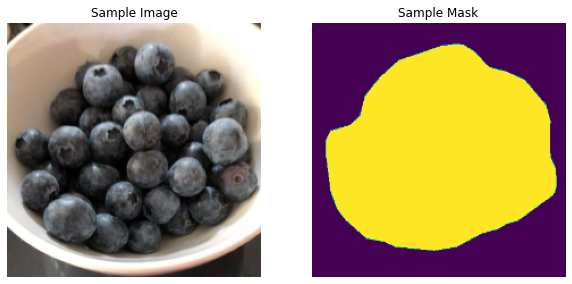

In [9]:
# Show sample images and masks
showSamp(images, masks, objects)

# Reference for Augmentation

https://github.com/aleju/imgaug

In [10]:
# Function to augment the images and masks
geo_seq = iaa.Sequential([
    iaa.Fliplr(1), # horizontally flip the images
])

int_seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 5.0)) # blur images with a sigma of 0 to 5.0
])

def augment_img(img, msk):
    geo_aug = geo_seq.to_deterministic()
    int_aug = int_seq.to_deterministic()
    
    # Apply geographic augmentation to image and mask
    img_aug = geo_aug.augment_image(img)
    msk_aug = geo_aug.augment_image(msk)
    
    # Apply intensity augmentation to image only
    img_aug = int_aug.augment_image(img_aug) 
    
    return img_aug, msk_aug

In [11]:
# Function to show an image and a mask along with their augments
def showAug(imgs, msks, n=None):
    plt.figure(figsize=(10, 10))
    length = len(imgs)
    
    if n is None:
        n = random.randrange(length)
        
    img_aug, msk_aug = augment_img(imgs[n], msks[n])
    
    ax1 = plt.subplot(2, 2, 1)
    ax1.imshow(imgs[n])
    ax1.axis('off')
    ax1.title.set_text('Original Image')
    
    ax2 = plt.subplot(2, 2, 2)
    ax2.imshow(img_aug)
    ax2.axis('off')
    ax2.title.set_text('Augmented Image')
    
    ax3 = plt.subplot(2, 2, 3)
    ax3.imshow(msks[n])
    ax3.axis('off')
    ax3.title.set_text('Original Mask')
    
    ax4 = plt.subplot(2, 2, 4)
    ax4.imshow(msk_aug)
    ax4.axis('off')
    ax4.title.set_text('Augmented Mask')    
    
    plt.show()

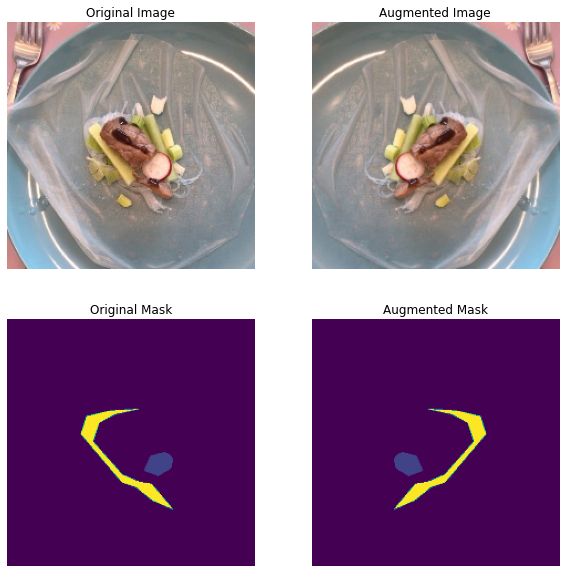

In [12]:
# Show sample images and masks with their augments
showAug(images, masks)

In [13]:
#  Function to create and shuffle a list of original and augmented images and masks
def getAugs(imgs, msks, K):
    length = len(imgs)
    
    img_lst = imgs.copy()
    msk_lst = msks.copy()
    
    for i in range(K):
        n = random.randrange(length)
        img_aug, msk_aug = augment_img(imgs[n], msks[n])
        
        img_lst.append(img_aug)
        msk_lst.append(msk_aug)
    
    # Shuffle all the original and augmented images and masks
    z = list(zip(img_lst, msk_lst))
    random.shuffle(z)
    img_lst, msk_lst = zip(*z)
    
    return img_lst, msk_lst

In [14]:
# Augment a given number of images and masks
aug_images, aug_masks = getAugs(images, masks, 10)

# Show the number of augmented images and masks
print('Number of augmented images: {}'.format(len(aug_images)))
print('Number of augmented masks: {}'.format(len(aug_masks)))

Number of augmented images: 1279
Number of augmented masks: 1279


# Reference for Model Building

https://github.com/qubvel/segmentation_models#quick-start

https://github.com/qubvel/segmentation_models/issues/374

In [15]:
# Install and import the segmentation models library
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 1.4 MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [16]:
# Define the model to be trained
BACKBONE = 'resnet34'
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

85524480/85521592 [==============================] - 1s 0us/step


In [17]:
# # Load the trained model weights
# weights_path = '../input/food-recognition-model/trained_model.h5'
# model.load_weights(weights_path)

In [18]:
# Train the defined model on the dataset
history = model.fit(x=np.array(aug_images), y=np.array(aug_masks), batch_size=16, epochs=20)

Epoch 1/20
80/80 [==============================] - 758s 9s/step - loss: 1.1873 - iou_score: 0.3217
Epoch 2/20
80/80 [==============================] - 750s 9s/step - loss: 0.8782 - iou_score: 0.4617
Epoch 3/20
80/80 [==============================] - 755s 9s/step - loss: 0.8060 - iou_score: 0.5023
Epoch 4/20
80/80 [==============================] - 745s 9s/step - loss: 0.7598 - iou_score: 0.5279
Epoch 5/20
80/80 [==============================] - 747s 9s/step - loss: 0.7348 - iou_score: 0.5435
Epoch 6/20
80/80 [==============================] - 747s 9s/step - loss: 0.6997 - iou_score: 0.5660
Epoch 7/20
80/80 [==============================] - 752s 9s/step - loss: 0.6745 - iou_score: 0.5836
Epoch 8/20
80/80 [==============================] - 748s 9s/step - loss: 0.6105 - iou_score: 0.6252
Epoch 9/20
80/80 [==============================] - 752s 9s/step - loss: 0.5820 - iou_score: 0.6345
Epoch 10/20
80/80 [==============================] - 756s 9s/step - loss: 0.5384 - iou_score: 0.6678

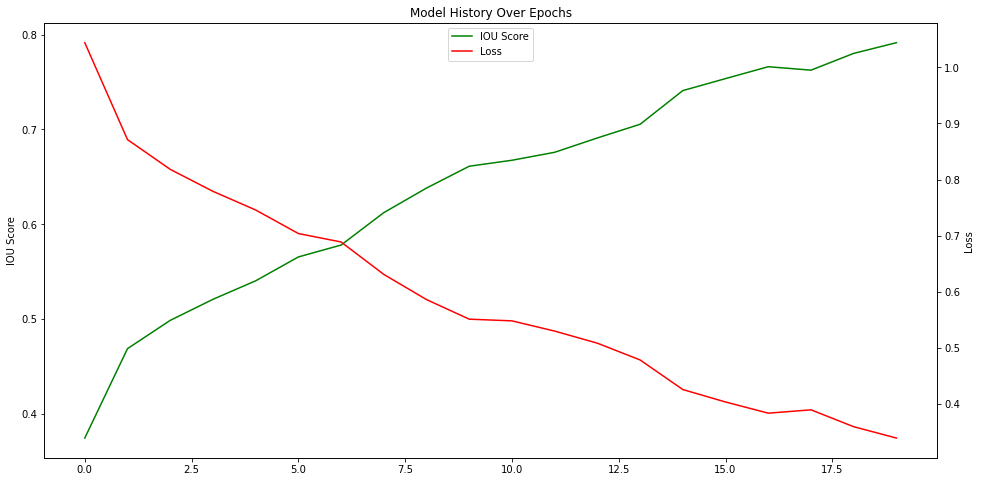

In [19]:
# Plot the loss and iou score over the epochs
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

p1, = ax1.plot(history.history['iou_score'], 'g')
ax1.set_ylabel('IOU Score')

p2, = ax2.plot(history.history['loss'], 'r')
ax2.set_ylabel('Loss')

ax1.legend([p1, p2], ['IOU Score', 'Loss'], loc='upper center')

plt.title('Model History Over Epochs')
plt.xlabel('Epochs')

plt.show()

In [20]:
# Save the model weights to the output
model.save_weights('trained_model.h5')